In [17]:
import numpy as np
import os
from scipy.linalg import solve
from scipy.signal import lfilter
from lpc.utils import *

from utils import plot, plot_audio

This time we want to estimate parameters of the vocal tract filter. 
We will work on 'a' and 'sz' sounds.

In [18]:
audio_dir = os.path.join('.', '..', 'audio')
fs = 8000

a_path = os.path.join(audio_dir, 'a.wav')
a_audio = get_audio(a_path)
sz_path = os.path.join(audio_dir, 'sz.wav')
sz_audio = get_audio(sz_path)

## Vocal tract filter
We shall assume that vocal tract filter that acts upon the base tone is an IIR filter with 10 coefficients. LPC-10 uses 10 for voiced sounds and 4 for unvoiced sounds but the following is just messing around.

In [19]:
window_len = int(0.03 * fs)
hamming = np.hamming(window_len)

offset = 10000  # large offset due to some artifacts(?) at the beginning of the recording 
a_window = a_audio[offset:offset + window_len][:, 0].astype(np.double)
sz_window = sz_audio[offset: offset + window_len][:, 0].astype(np.double)

a_window *= hamming
sz_window *= hamming

In [20]:
n_coef = 10

def find_coef(arr):
    r_arr = np.correlate(arr, arr, mode='same')
    r_arr = r_arr[len(r_arr) // 2:]
    
    r_matrix = np.empty((n_coef, n_coef))
    for i in range(n_coef):
        r_matrix[i, i:] = r_arr[:n_coef - i]
        r_matrix[i, :i] = r_arr[i:0:-1]
        
    coef = solve(r_matrix, -r_arr[1:n_coef + 1], assume_a='sym')
    G = r_arr[0] + np.dot(r_arr[1:n_coef + 1], coef)
    
    return G, coef

In [21]:
G, coef = find_coef(a_window)

So we found some coefficients. In **vocal_source_estimation** we found 112.68 Hz base tone frequency for 'a'. Let's try  and feed filter of these coefficients with signal consisting of Dirac deltas spaced accordingly to that base tone frequency.

In [22]:
a_base_period = 0.008875
a_bp_s = int(a_base_period * fs)

a_base_tone = np.zeros(window_len)
a_base_tone[::a_bp_s] = 1

In [23]:
b = np.array([G])
a = np.concatenate([np.array([1]), coef])

a_filtered = lfilter(b, a, a_base_tone)

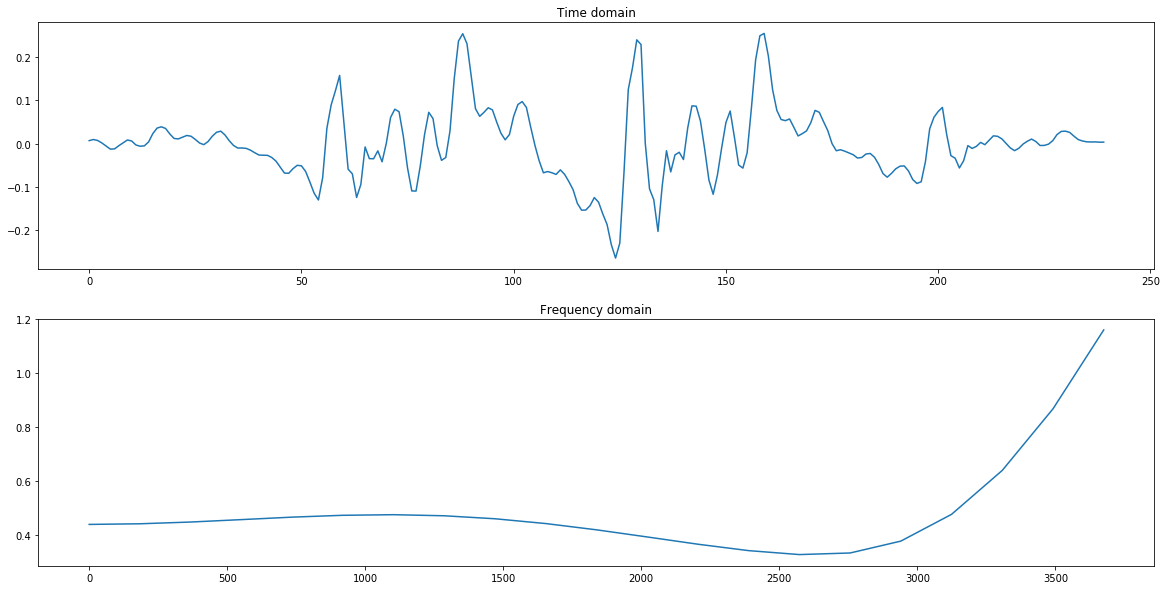

In [24]:
plot_audio(a_window)

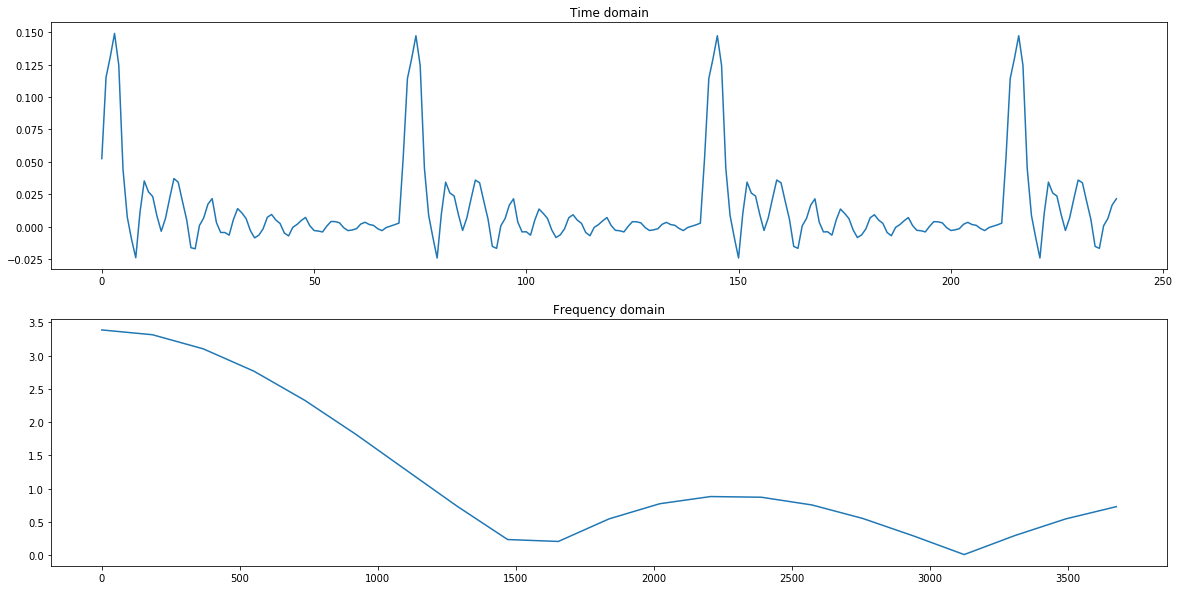

In [25]:
plot_audio(a_filtered)

Well... Let's check out 'sz' also. Because it is unvoiced, we feed the filter with white noise instead of a periodic signal.

In [26]:
G_sz, coef_sz = find_coef(sz_window)

In [27]:
sz_noise = np.random.uniform(-1, 1, size=window_len)
b_sz = np.array([G_sz])
a_sz = np.concatenate([np.array([1]), coef_sz])

sz_filtered = lfilter(b_sz, a_sz, sz_noise)

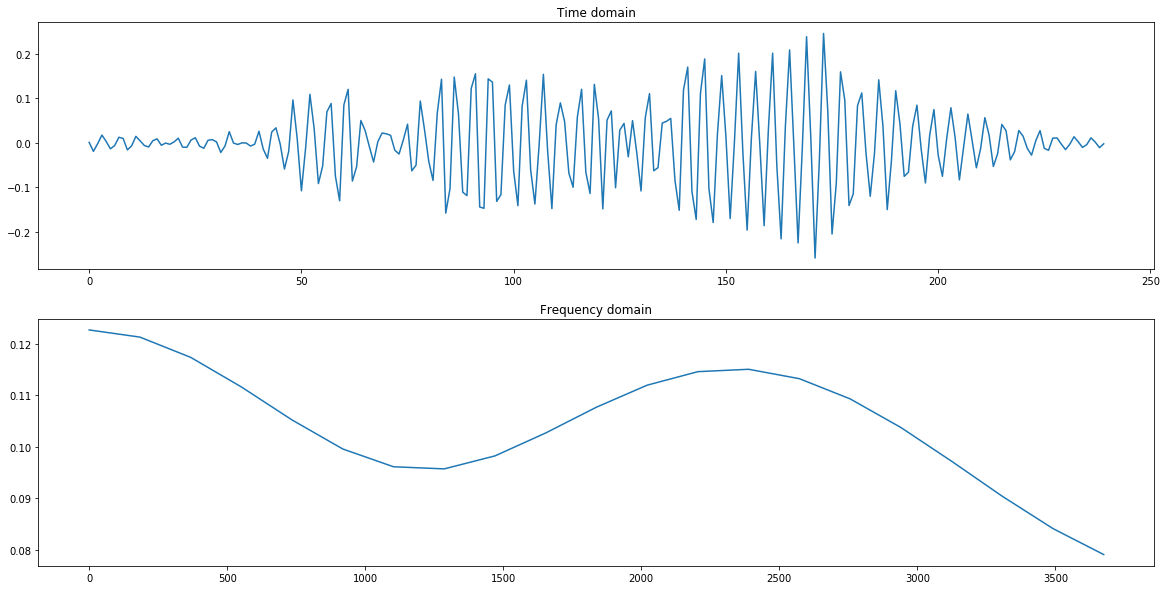

In [28]:
plot_audio(sz_window)

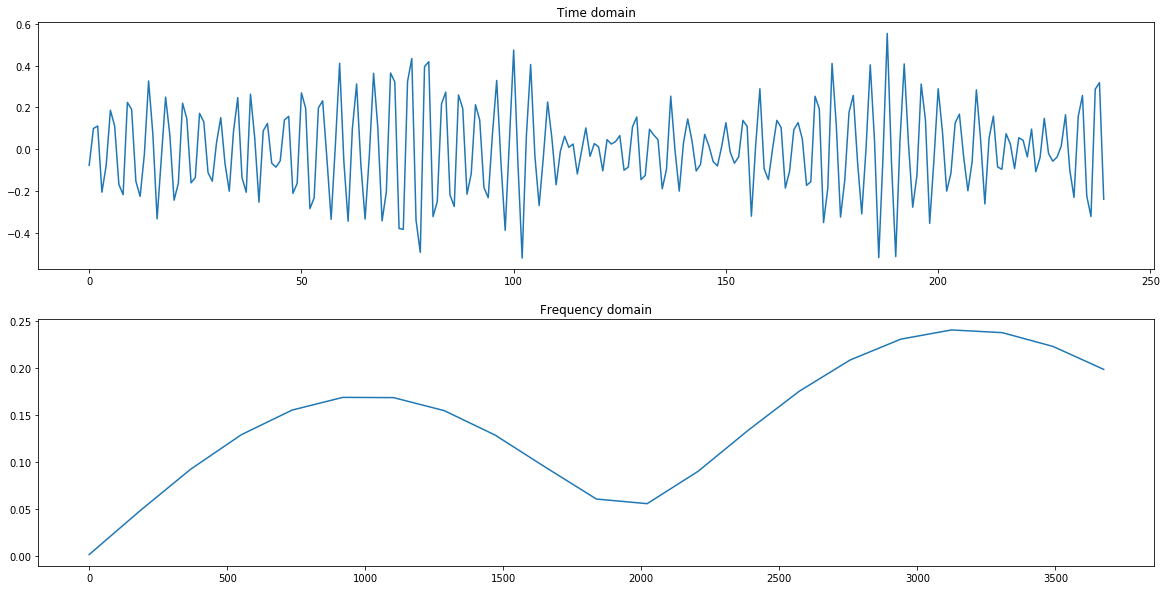

In [29]:
plot_audio(sz_filtered)

That looks better (in the time domain) but still it's rather crap. But that's just a single time frame, let's put all these steps together for a longer audio recording and see what happens!